# scanpy

## Aims:

+ single cell RNASeq with scanpy

This workflow of scanpy is based on kallisto!!
https://kallisto.readthedocs.io/en/latest/sc/notebooks/scanpy.html

Kallisto also has other pipelines using scanpy, 

+ single nuclear pipeline https://kallisto.readthedocs.io/en/latest/sc/notebooks/scanpy_nucleus.html#

+ long read workflow 
https://kallisto.readthedocs.io/en/latest/lr/pseudoalignment.html#long-read-pseudoalignment-of-single-cell-rna-seq-data

future Ref to follow:
https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html

In [1]:
import os
from importlib.util import find_spec 

if not find_spec("scanpy"):
    ! uv add scanpy
else: 
    print(f"Scanpy has been found in the environment!!!")

import scanpy
import time
start_time = time.time()

Scanpy has been found in the environment!!!


/config/workspace/.venv/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
# Import packages
import anndata
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io

matplotlib.rcParams.update({'font.size': 12})
set_matplotlib_formats('retina')

In [43]:
import louvain

import os.path

# %%time
if not os.path.isfile("SC3_v3_NextGem_SI_PBMC_CSP_1K_fastqs.tar"):
    !wget -q https://cf.10xgenomics.com/samples/cell-exp/4.0.0/SC3_v3_NextGem_SI_PBMC_CSP_1K/SC3_v3_NextGem_SI_PBMC_CSP_1K_fastqs.tar
else :
    print("file already exists, skip downloading..........")
#
if not os.path.isdir("SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs"):
    #folde doesn't exist
    !tar -xf SC3_v3_NextGem_SI_PBMC_CSP_1K_fastqs.tar
else : #folder exist need to check content
    if next(os.scandir("SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs"), None) is None:
        !tar -xf SC3_v3_NextGem_SI_PBMC_CSP_1K_fastqs.tar
    else: 
        print("not empty")
#!tar -xf SC3_v3_NextGem_SI_PBMC_CSP_1K_fastqs.tar

file already exists, skip downloading..........
not empty


Download a human reference index, which are premade.
https://kallisto.readthedocs.io/en/latest/index/index_generation.html

In [46]:
if not (os.path.isfile("index.idx") and os.path.isfile("t2g.txt")):
    print("need to down load index")
    !kb ref -d human -i index.idx -g t2g.txt

## build an index (NOTE: build from genome and annotation data, fasta and gtf/gff respectively). But we downloaded premade by kb above!!

See more details in the tutorial on building an index

        # # building a standard custom reference from the human genome
        # !kb ref -i index.idx -g t2g.txt -f1 f1.fa human_reference_path.fa human_gtf_path.gtf

        # # building a custom reference from the human genome with k=55 (where k is the size of each k-mer used in pseudoalignment)
        # !kb ref -i index.idx -g t2g.txt -f1 f1.fa -k 55 human_reference_path.fa human_gtf_path.gtf

        # # building a reference with the nac workflow (will detect both splice-aware and unspliced transcripts)
        # !kb ref -i index.idx -g t2g.txt -f1 f1.fa --workflow=nac -f2 f2.fa -c1 c1.txt -c2 c2.txt human_reference_path.fa human_gtf_path.gtf

## Pseudoaligning the scRNA-seq data to the index with kb count

In [50]:
#%%time
# This step runs `kb` to pseudoalign the reads, and then generate the cells x gene matrix in h5ad format.
if os.path.isdir("counts_unfiltered") and next(os.scandir("counts_unfiltered"), None) is not None:
    print("folder exist and not empty")
else:
    !kb count -i index.idx -g t2g.txt -x 10XV3 --h5ad -t 2 \
    SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_S1_L002_R1_001.fastq.gz \
    SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_S1_L002_R2_001.fastq.gz \
    SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_S1_L003_R1_001.fastq.gz \
    SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_S1_L003_R2_001.fastq.gz \
    SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_S1_L004_R1_001.fastq.gz \
    SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_S1_L004_R2_001.fastq.gz

folder exist and not empty


In [51]:
# import data
adata = anndata.read_h5ad('counts_unfiltered/adata.h5ad')
adata

AnnData object with n_obs × n_vars = 281262 × 39546

Represent the cells in 2D with PCA

This is one type of embedding in which cells in higher dimensional gene expression space are represented in two dimensions.

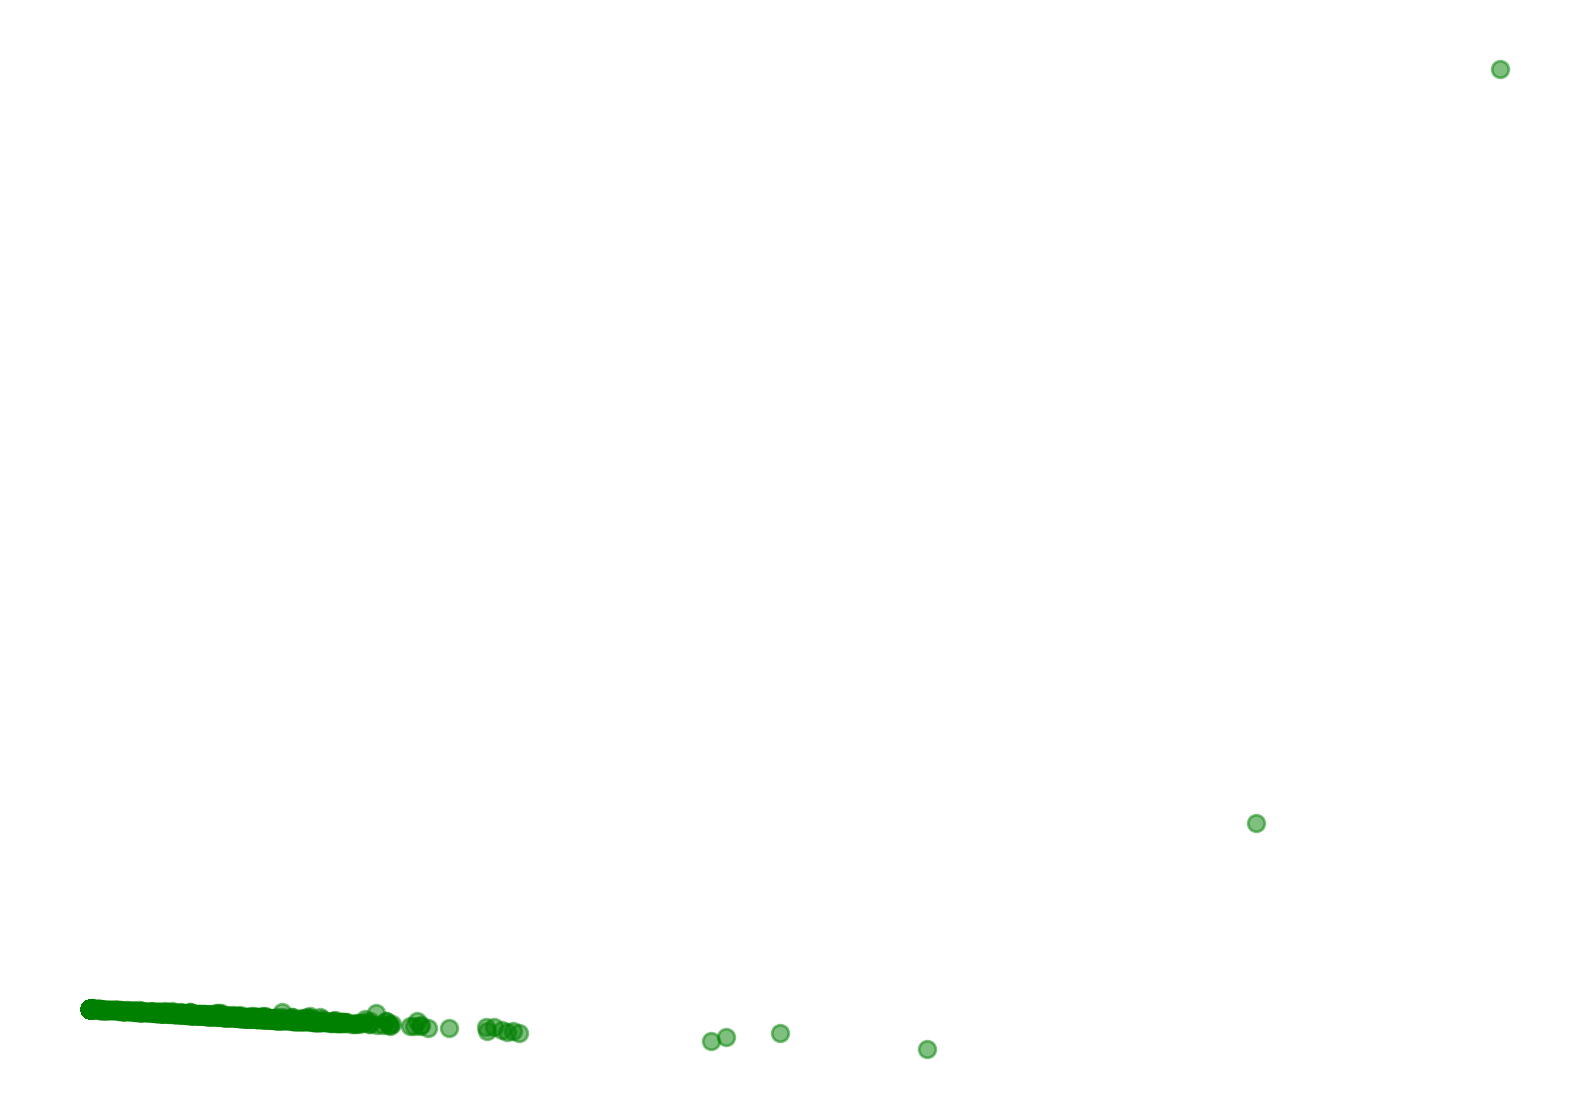

In [52]:
# Perform SVD
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(adata.X)
X = tsvd.transform(adata.X)

# Plot the cells in the 2D PCA projection
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(X[:,0], X[:,1], alpha=0.5, c="green")

plt.axis('off')
plt.show()

Test for library saturation
For each cell we ask how many genes did we detect (or see non-zero expression). The idea is that if we have “saturated” our sequencing library then increasing the number of UMI counts (x-axis) will not yield an appreciable increase in the number of genes detected (y-axis).

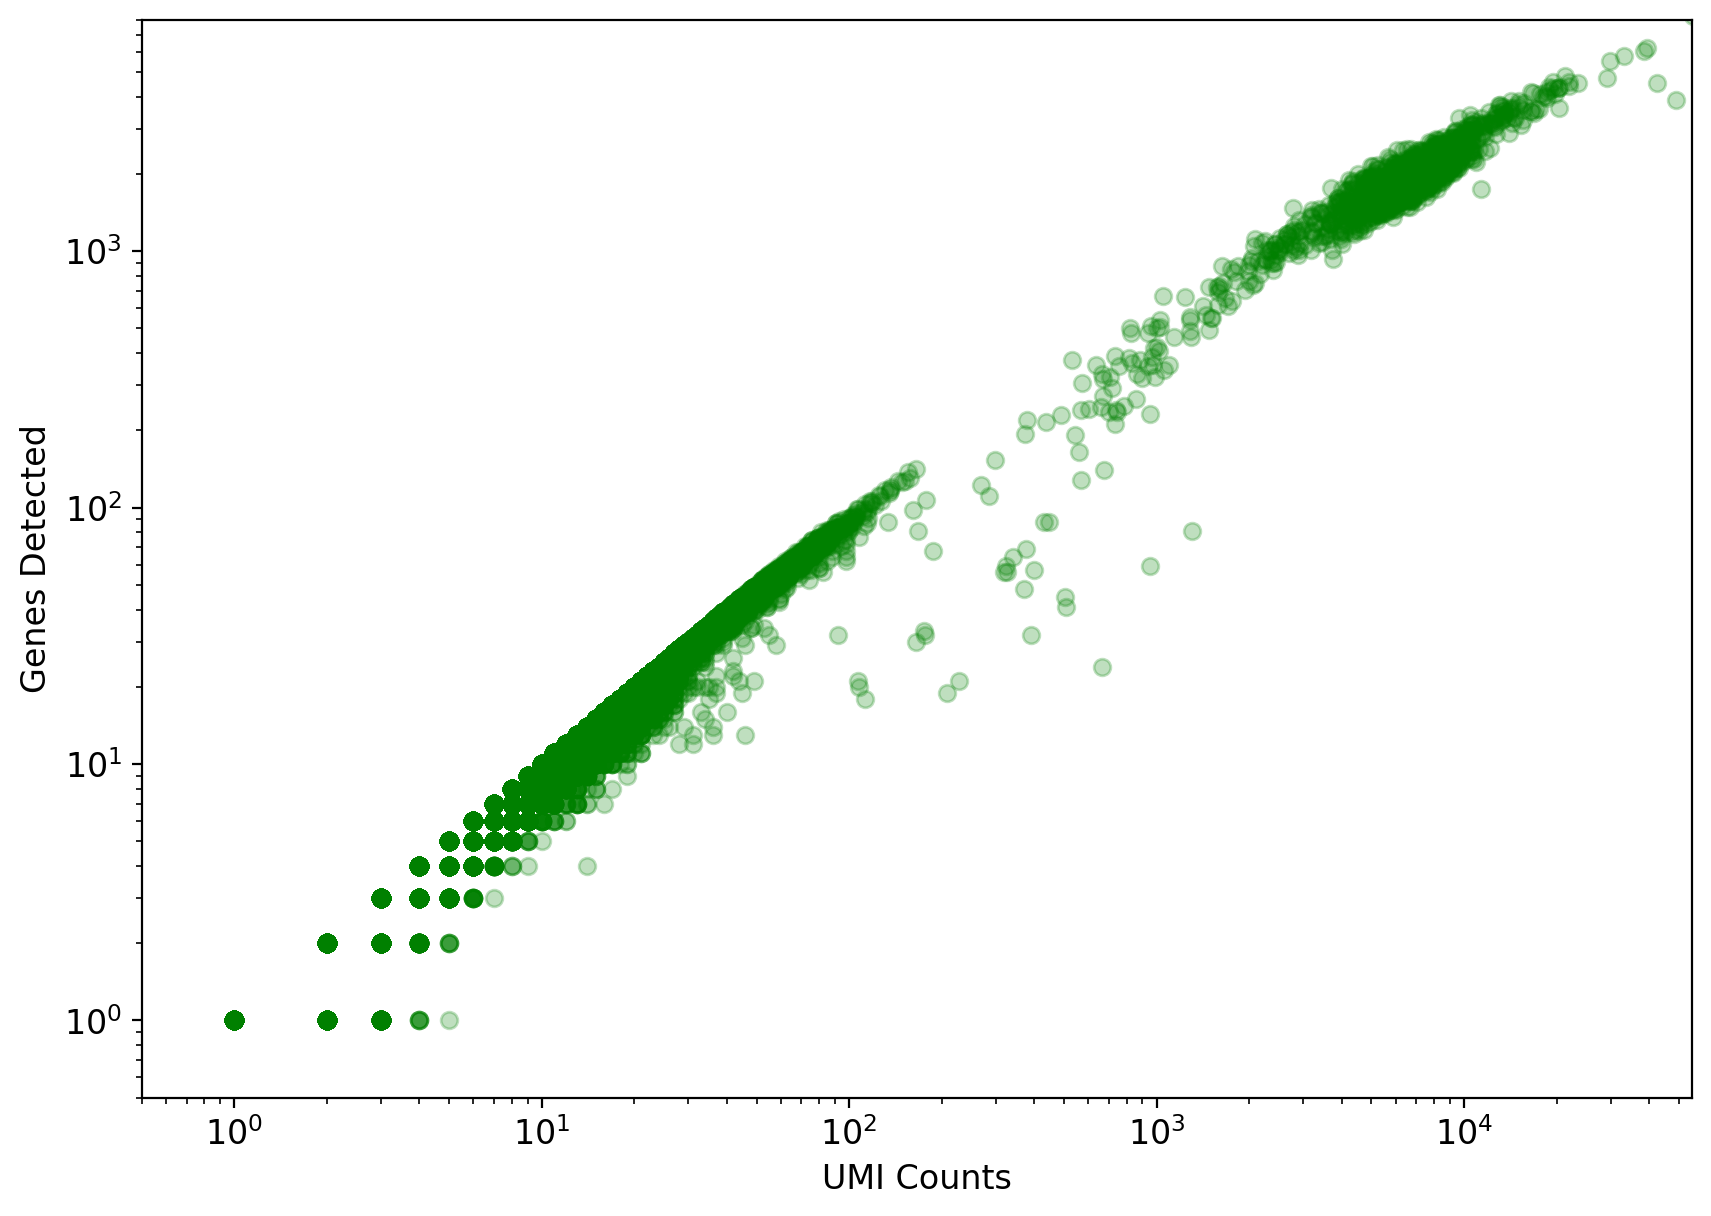

In [53]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')

ax.set_xlim((0.5, 55000))
ax.set_ylim((0.5,8000))


plt.show()

## Examine the knee plot

The “knee plot” was introduced in the Drop-seq paper:

Macosko et al., Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets, 2015. DOI:10.1016/j.cell.2015.05.002

In this plot cells are ordered by the number of UMI counts associated to them (shown on the x-axis), and the fraction of droplets with at least that number of cells is shown on the y-axis. The idea is that “real” cells have a certain number of UMI counts and that a threshold on the UMI counts filters those cells.

knee array:f[55594. 48900. 42295. ...     0.     0.     0.]


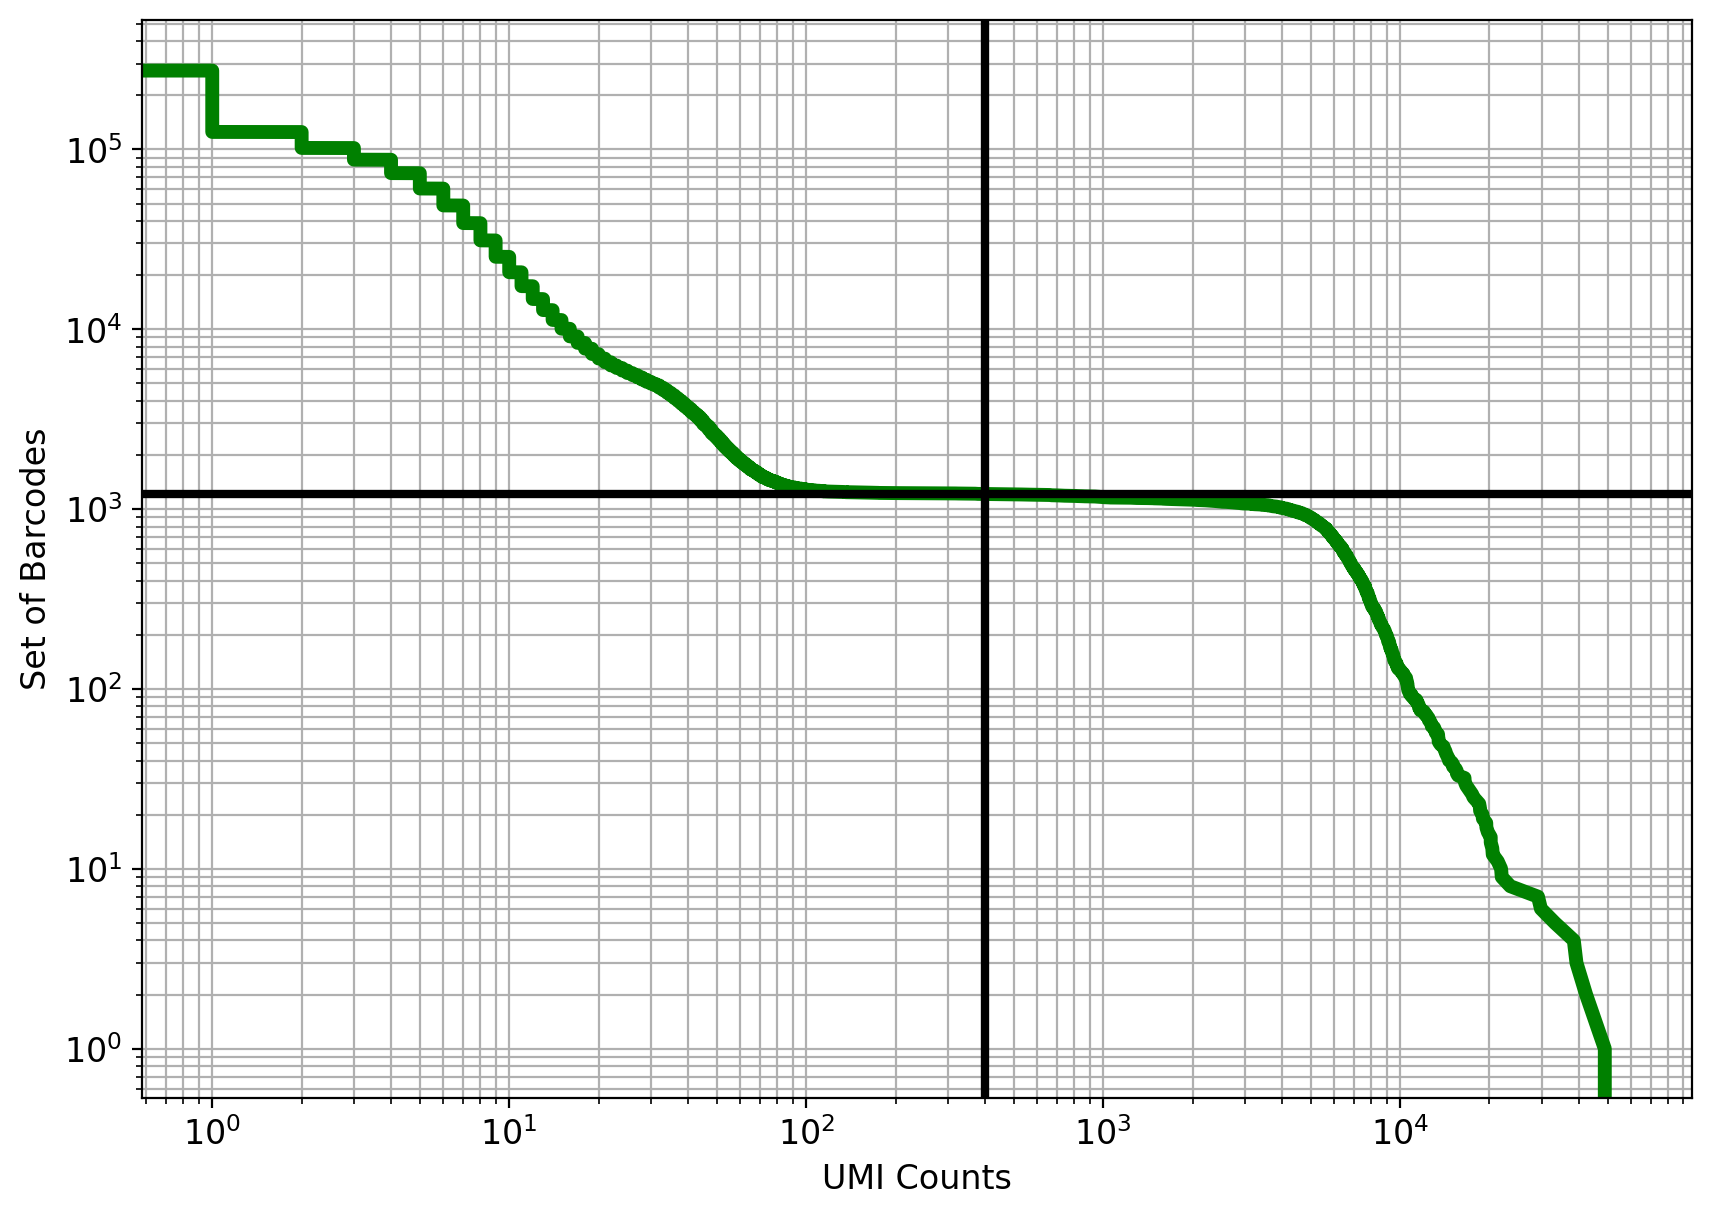

In [54]:
cutoff = 400  #@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
print(f"knee array:f{knee}")
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [55]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")



1,212 cells passed the 400 UMI threshold


The knee plot can be used to threshold cells based on the number of UMI counts they contain. The threshold is applied at the “knee”, where there is a sharp dropoff in the number of UMIs per cell. In this example we use the number 3979 based on the publication describing the data.

## Filter empty droplets


In [56]:
print(f" Before filtering: {adata}")
num_cells=3979
# Filter the cells according to the threshold determined from the knee plot
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, min_counts=knee[num_cells])

print(f" After filtering: {adata}")

 Before filtering: AnnData object with n_obs × n_vars = 281262 × 39546
 After filtering: AnnData object with n_obs × n_vars = 1203 × 39546
    obs: 'n_genes', 'n_counts'


## Filtering out by mitochondrial content


In [57]:
mito_ensembl_ids = sc.queries.mitochondrial_genes("hsapiens", attrname="ensembl_gene_id")
print(mito_ensembl_ids[1:3])
print(type(mito_ensembl_ids))
mito_genes = set(mito_ensembl_ids["ensembl_gene_id"].values) #this is a set, so to make sure no duplicate
print(mito_genes)
print(len(mito_genes))

adata_base_var_names = adata.var_names.str.split('.').str[0]  # Removes minor version from var names
mito_genes_base = {gene.split('.')[0] for gene in mito_genes}  # Removes minor version from mito_genes
        #this is a set, meaning dictionary is basically a set????
print(type(mito_genes_base))

   ensembl_gene_id
1  ENSG00000211459
2  ENSG00000210077
<class 'pandas.core.frame.DataFrame'>
{'ENSG00000210112', 'ENSG00000198695', 'ENSG00000210077', 'ENSG00000210049', 'ENSG00000198712', 'ENSG00000210151', 'ENSG00000210100', 'ENSG00000210154', 'ENSG00000198899', 'ENSG00000210140', 'ENSG00000198888', 'ENSG00000209082', 'ENSG00000210174', 'ENSG00000198938', 'ENSG00000212907', 'ENSG00000228253', 'ENSG00000198727', 'ENSG00000210107', 'ENSG00000210144', 'ENSG00000210117', 'ENSG00000210196', 'ENSG00000198763', 'ENSG00000210195', 'ENSG00000198840', 'ENSG00000210176', 'ENSG00000198886', 'ENSG00000210194', 'ENSG00000198786', 'ENSG00000210127', 'ENSG00000210156', 'ENSG00000210164', 'ENSG00000211459', 'ENSG00000210082', 'ENSG00000198804', 'ENSG00000210191', 'ENSG00000210135', 'ENSG00000210184'}
37
<class 'set'>


In [59]:
# Identify mitochondrial genes in adata.var using the stripped version of gene IDs
adata.var['is_mito'] = adata_base_var_names.isin(mito_genes_base)
print(len(adata.var))
print(type(adata.var))

mito_counts = adata[:, adata.var['is_mito']].X.sum(axis=1)
print(f"mito_counts:f{mito_counts}")

# Calculate total counts per cell
total_counts = adata.X.sum(axis=1)
print(f"total_counts:{total_counts}")

print(f"adata.var.shape:{adata.var.shape}")
print(f"adata.X.shape:{adata.X.shape}")
print(f"adata.obs.shape:{adata.obs.shape}")
print(f"obs:{adata.obs}")
# Calculate percent mitochondrial gene expression per cell
adata.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()

adata.obs['n_counts'] = adata.X.sum(axis=1).A1

39546
<class 'pandas.core.frame.DataFrame'>
mito_counts:f[[261.]
 [392.]
 [443.]
 ...
 [257.]
 [661.]
 [127.]]
total_counts:[[ 701.]
 [6492.]
 [5741.]
 ...
 [2600.]
 [5925.]
 [5422.]]
adata.var.shape:(39546, 1)
adata.X.shape:(1203, 39546)
adata.obs.shape:(1203, 3)
obs:                  n_genes  n_counts  percent_mito
barcode                                          
AAACCCAGTACCAGAG      235     701.0     37.232525
AAACGCTTCGGTCTGG     1802    6492.0      6.038201
AAACGCTTCGTTGCCT     1931    5741.0      7.716426
AAAGAACAGGAACTCG     1404    4112.0     11.186770
AAAGGATAGGTCGAGT     2289    7488.0     12.326389
...                   ...       ...           ...
TTTCCTCAGGACAGCT      230     489.0     15.950920
TTTCCTCGTCACTCGG     2097    7561.0      7.869329
TTTCGATTCTGTCAGA     1107    2600.0      9.884615
TTTGATCCAAGTGGGT     2189    5925.0     11.156118
TTTGGTTCAAGTGGTG     1539    5422.0      2.342309

[1203 rows x 3 columns]


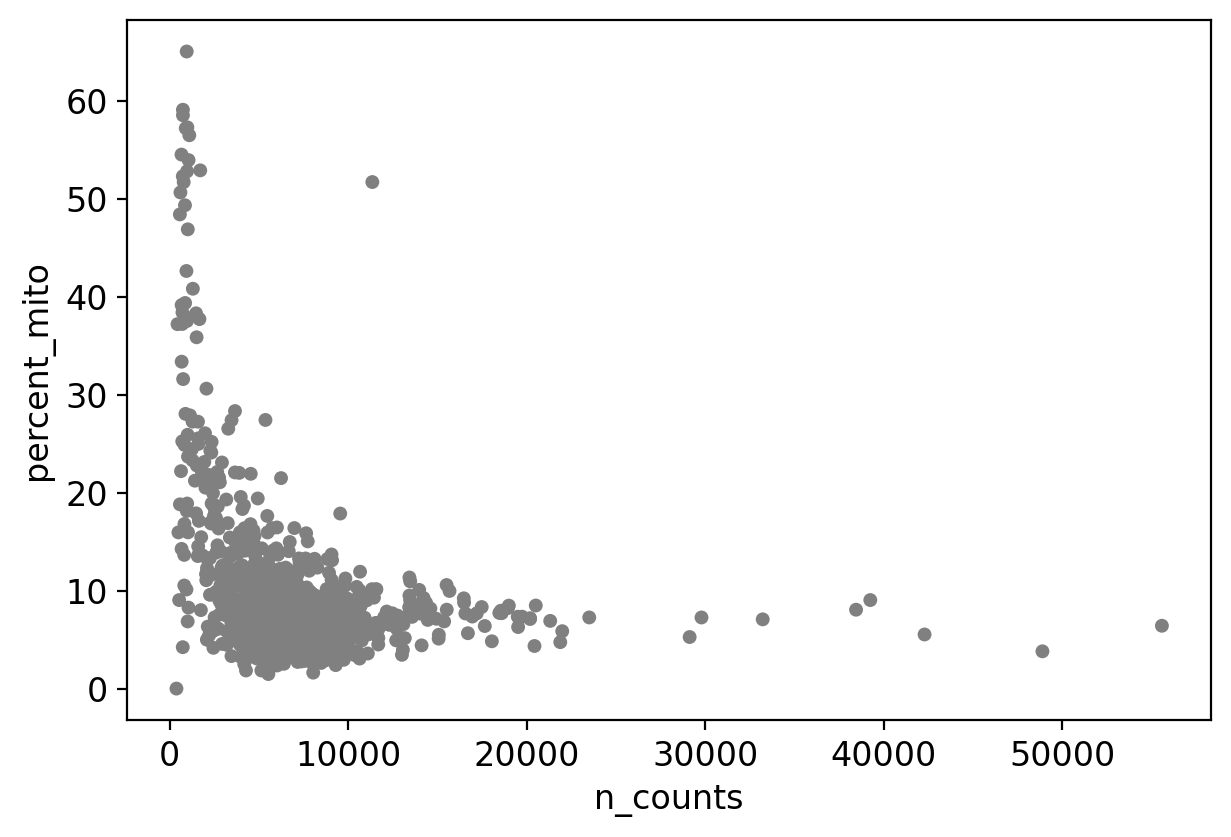

In [60]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')

In [61]:
adata = adata[adata.obs.percent_mito < 30]
adata

View of AnnData object with n_obs × n_vars = 1171 × 39546
    obs: 'n_genes', 'n_counts', 'percent_mito'
    var: 'is_mito'

Filter out genes that are not present in any cells


In [62]:
sc.pp.filter_genes(adata, min_cells=3)
adata

/config/workspace/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


AnnData object with n_obs × n_vars = 1171 × 17140
    obs: 'n_genes', 'n_counts', 'percent_mito'
    var: 'is_mito', 'n_cells'

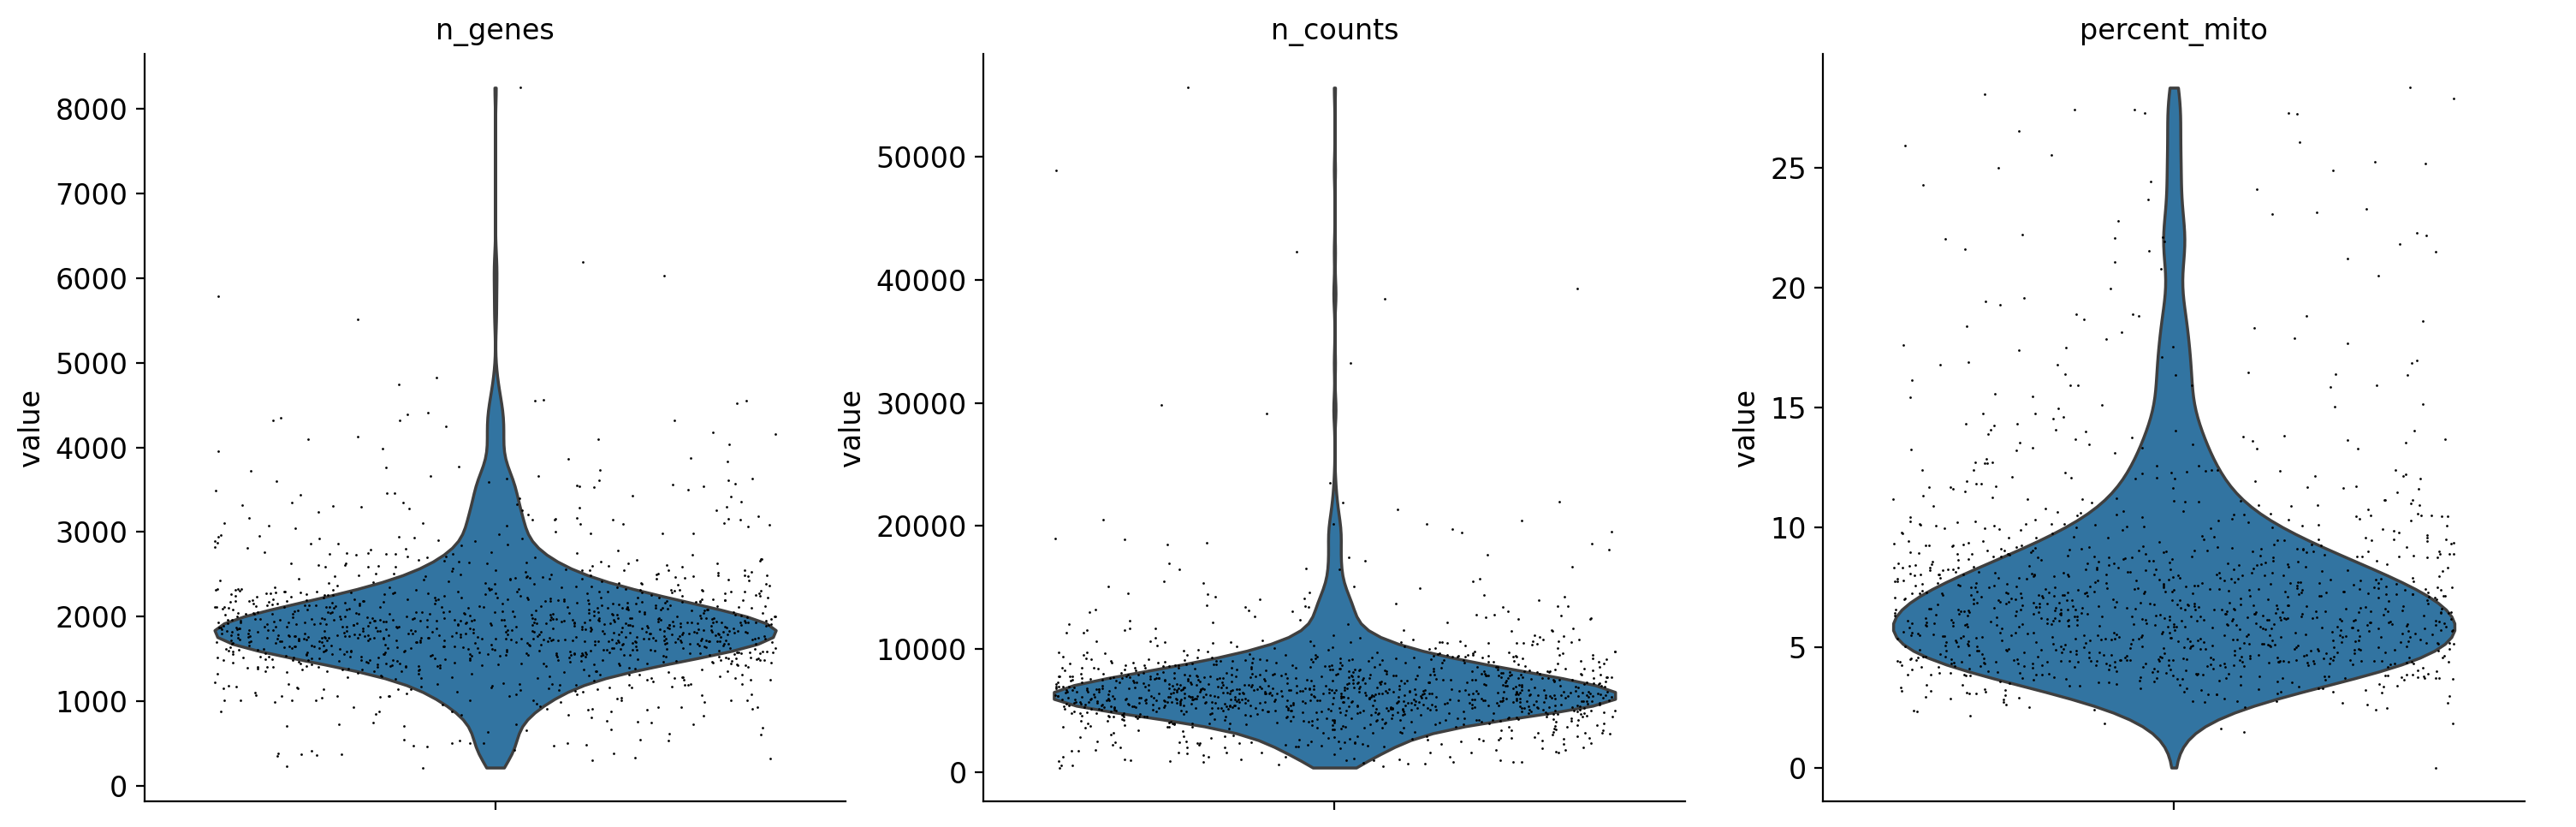

In [63]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

In [68]:
#sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
#sc.pp.log1p(adata)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

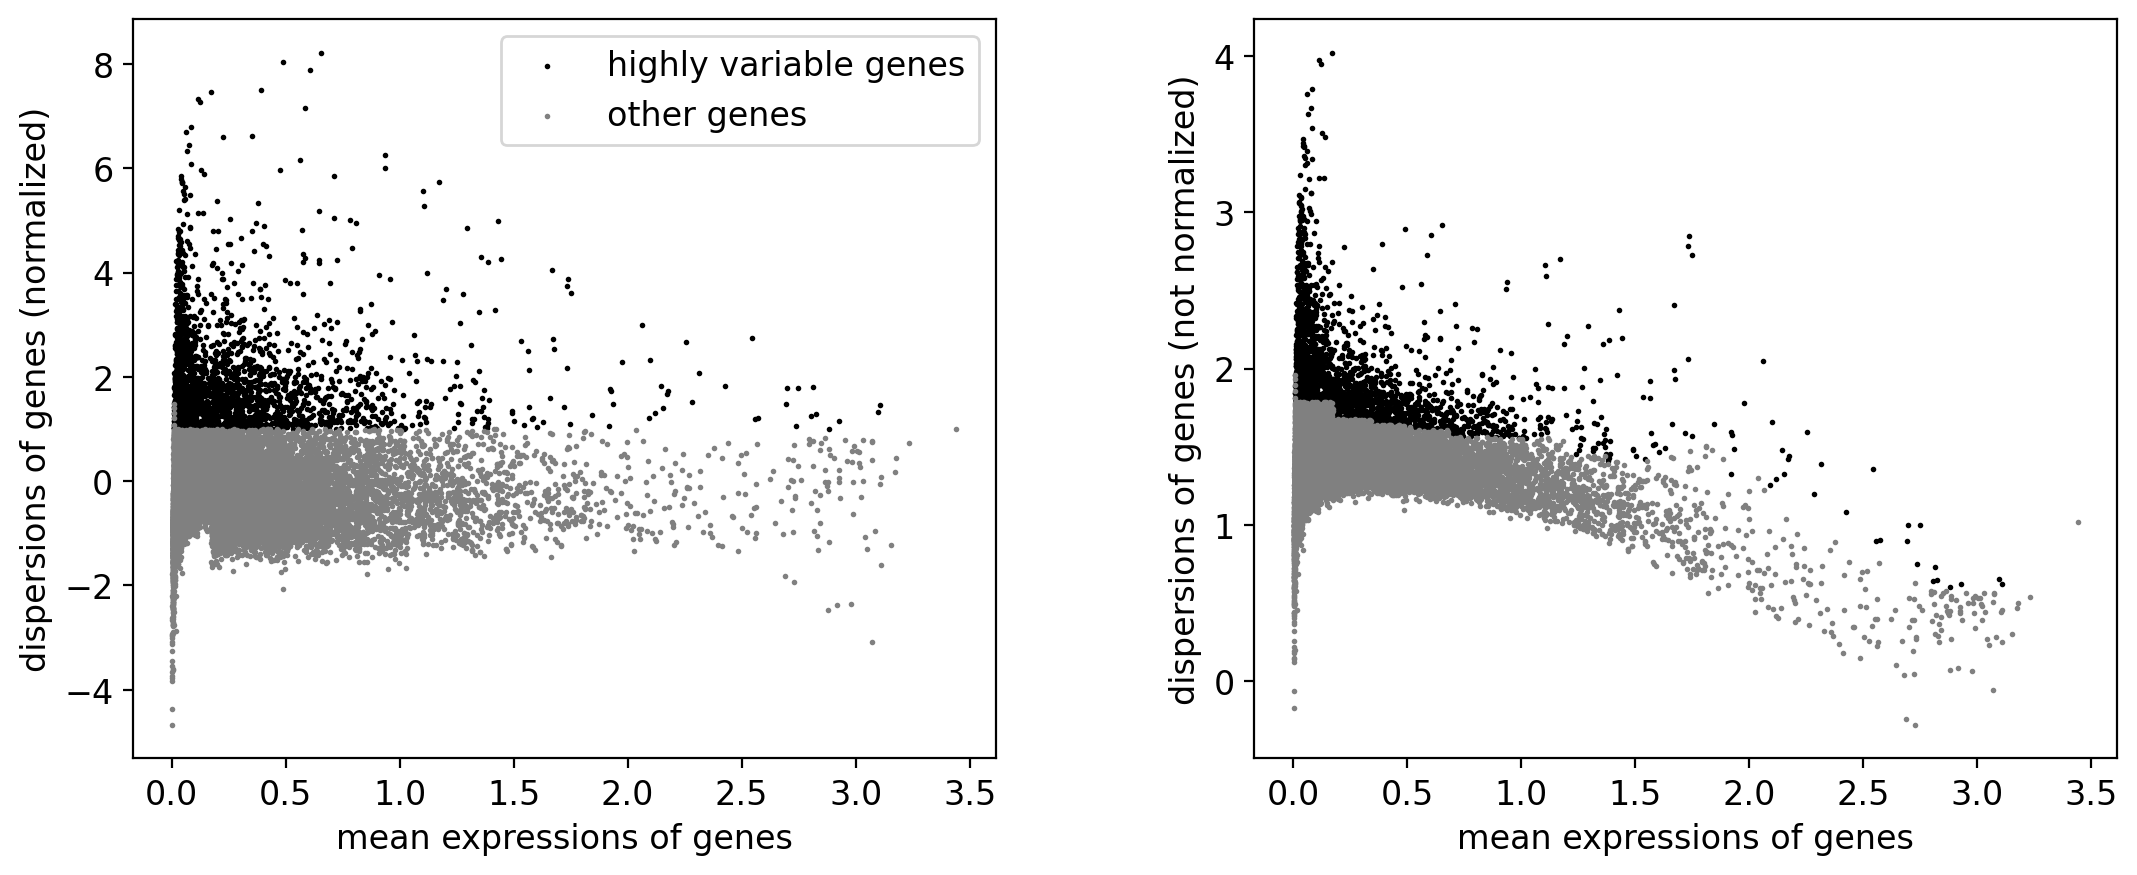

In [69]:
# flavor="cell_ranger" is consistent with Seurat and flavor="suerat" is not consistent with Seurat
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=8, min_disp=1, n_bins=20, flavor="seurat")
sc.pl.highly_variable_genes(adata)

In [70]:
sc.pp.scale(adata, max_value=10)

/config/.local/share/uv/python/cpython-3.10.19-linux-x86_64-gnu/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


## Clustering and visualization
There are many algorithms for clustering cells, and while they have been compared in detail in various benchmarks (see e.g., Duo et al. 2018), there is no univerally agreed upon method. Here we demonstrate clustering using Louvain clustering, which is a popular method for clustering single-cell RNA-seq data. The method was published in

In [71]:
sc.tl.pca(adata, svd_solver='arpack', mask_var="highly_variable", n_comps=10)

In [72]:
# Cluster the cells using Louvain clustering
sc.tl.pca(adata, svd_solver='arpack', mask_var="highly_variable", n_comps=10)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10, knn=True)
sc.tl.louvain(adata)

/config/workspace/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


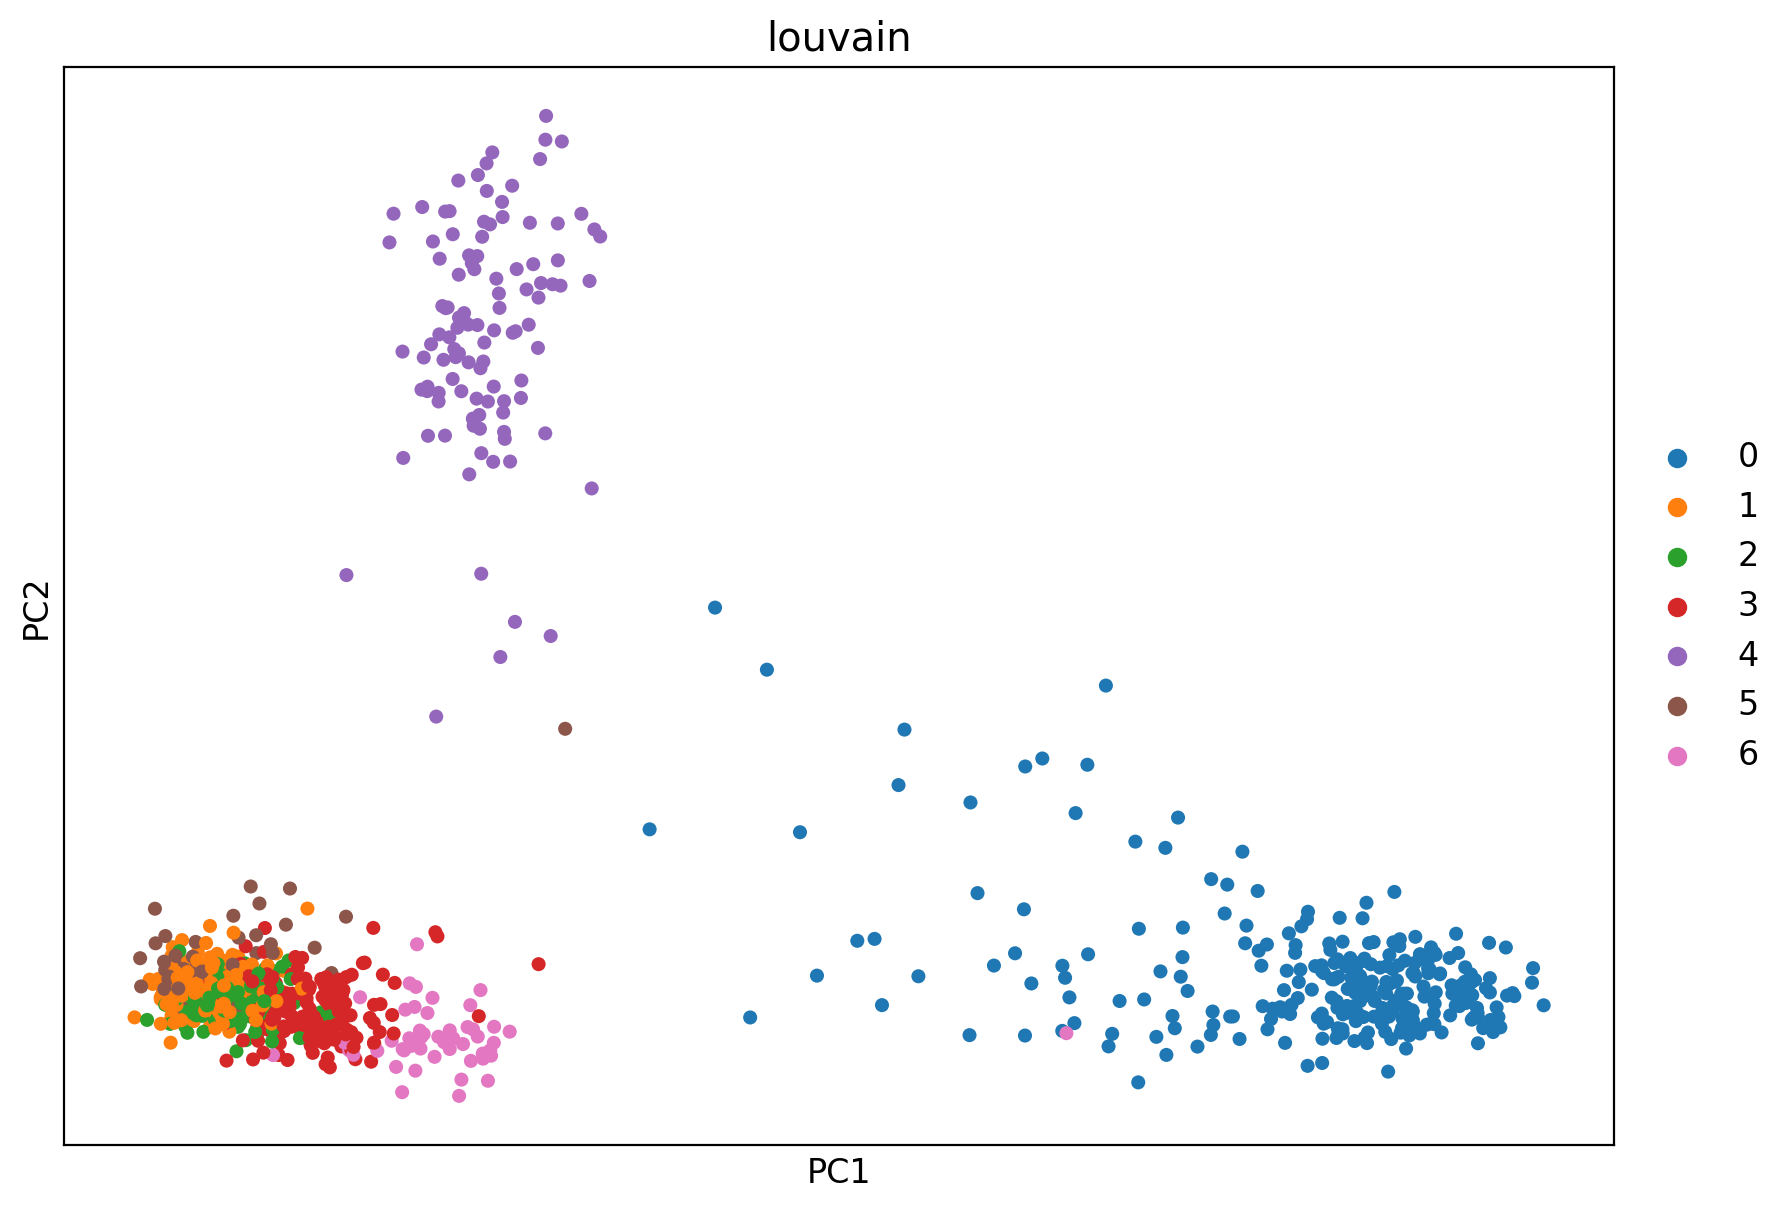

In [73]:
# PCA
# Perform PCA and plot the projection to the first two dimensions, with points colored according to the Louvain clusters.
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.pca(adata, color='louvain', ax=ax)

Visualization
Visualization of the clustered data can be accomplished through non-linear dimensionality reduction, often with UMAP or t-SNE. Our group has demonstrated that both UMAP and t-SNE’s non-linear natures make their interpretability highly limited. To read more, please see the following reference:

Chari T, Pachter L. The Specious Art of Single-Cell Genomics [Internet]. Genomics; 2021 Aug [cited 2023 Sep 6]. Available from: http://biorxiv.org/lookup/doi/10.1101/2021.08.25.457696

However, for those still interested in these methods, we demonstrate their use below.

t-SNE

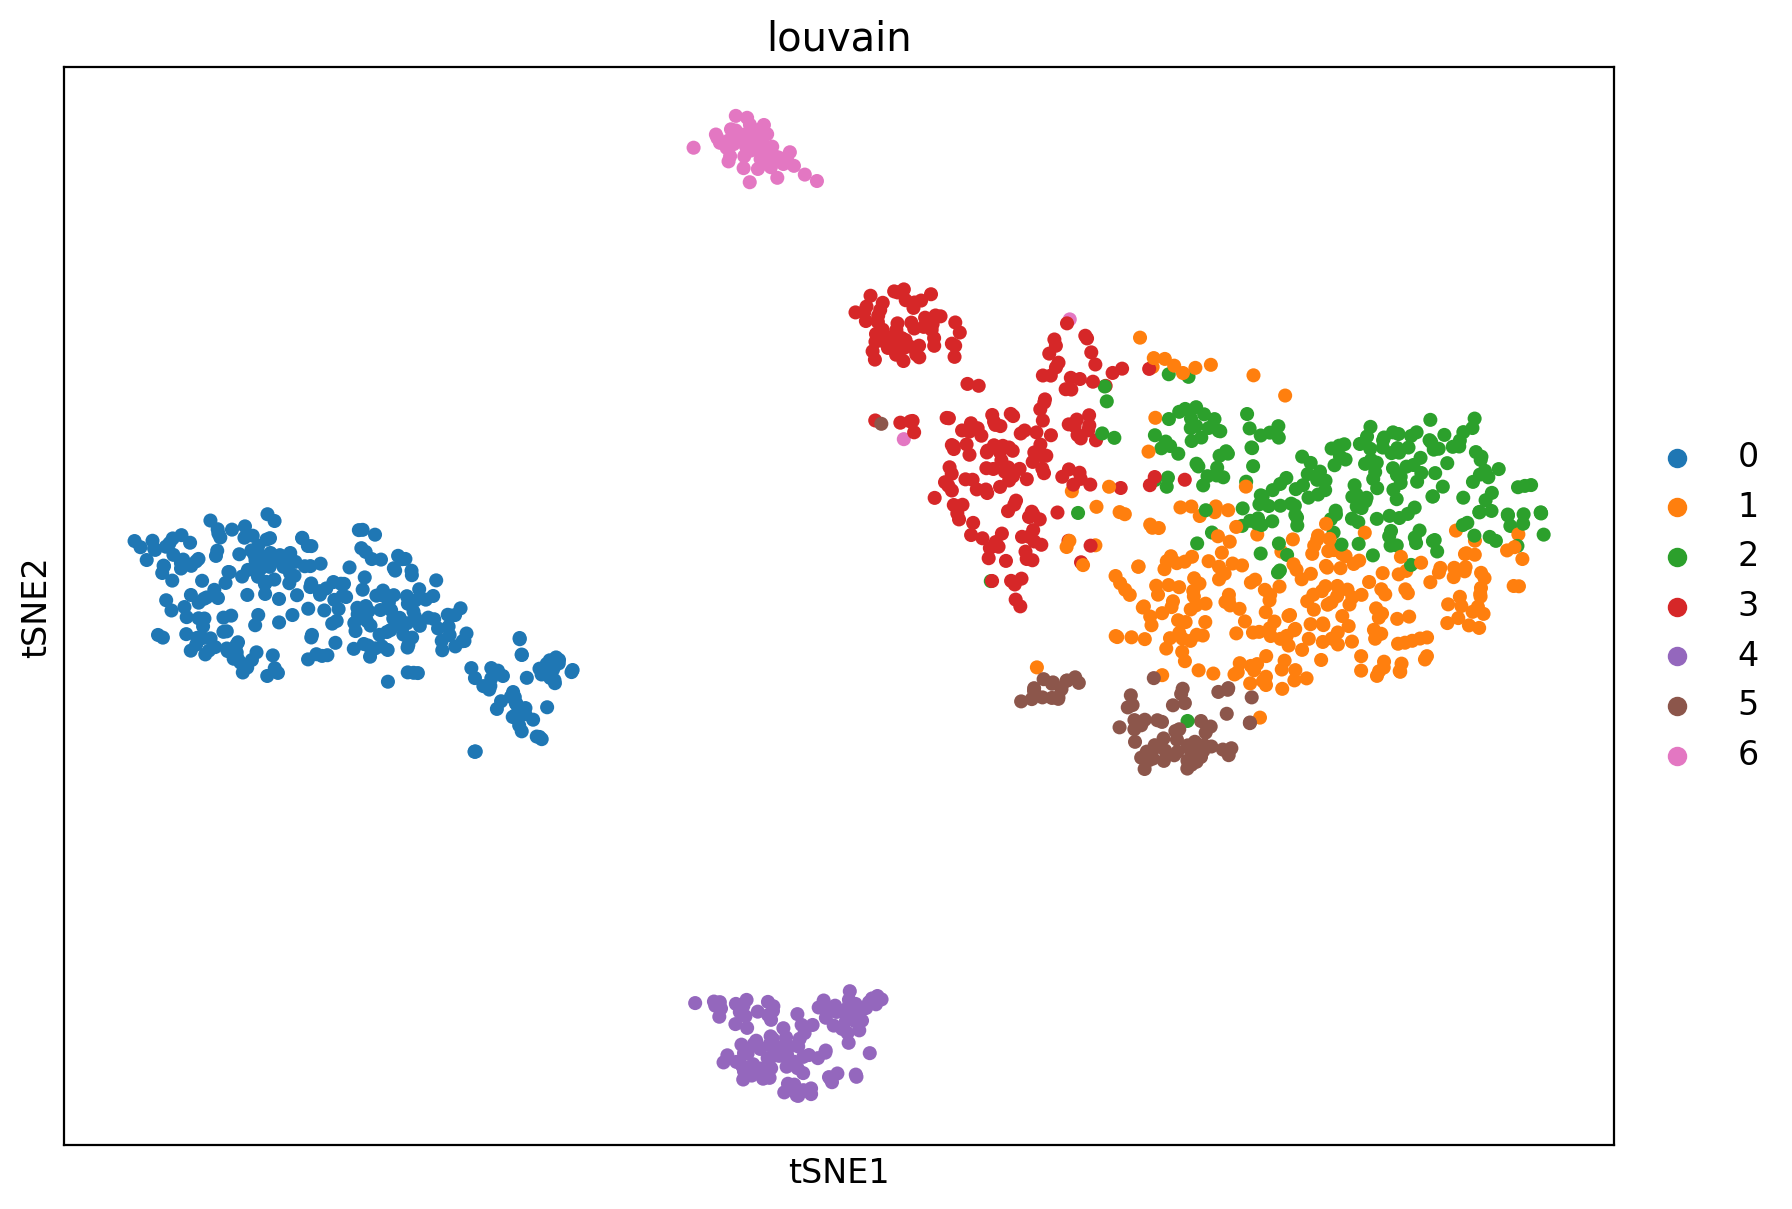

In [74]:
# Visualize cells with t-SNE. The n_pcs parameter sets the number of principal components to project to prior to
# performing t-SNE
sc.tl.tsne(adata, n_pcs=10)
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.tsne(adata, color='louvain', ax=ax)

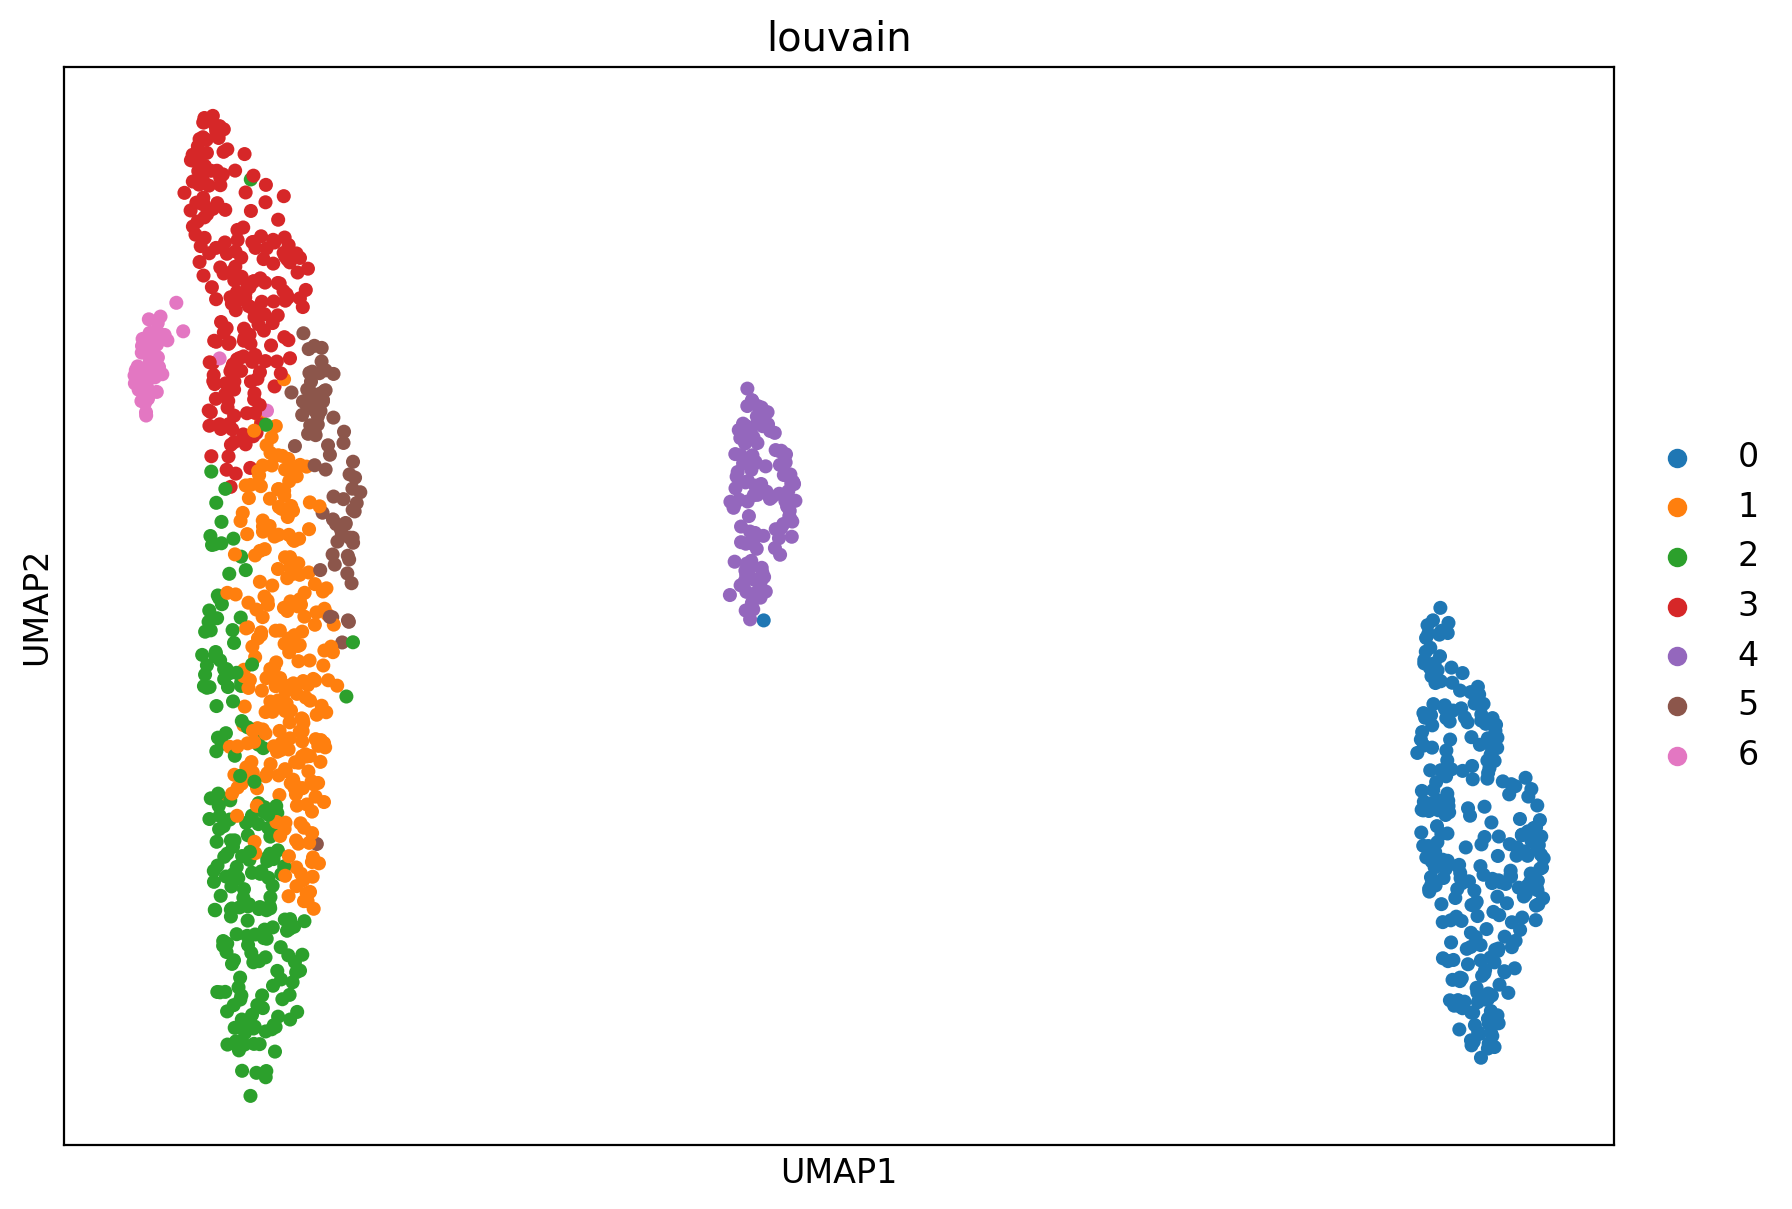

In [75]:
#UMP

sc.tl.umap(adata)
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata, color='louvain', ax=ax)